In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.share import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on
re,Support for regular expressions (RE)
time,This module provides various functions to manipulate time values
inspect,Get useful information from live Python objects


In [2]:
# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 50)

TESTSETNAME = 'allset_test.hdf'

In [3]:
# defining function to plot evaluations metric per feature and hyperparameter
def evalinfo(sem_df, score, sem_df_hyperparams = None):
    printhtml('<h3>%s</h3>' % score)
    
    if sem_df_hyperparams is None:
        sem_df_hyperparams = sem_df

    n_estimators = np.unique(sem_df_hyperparams.n_estimators.values)
    max_samples = np.unique(sem_df_hyperparams.max_samples.values)
    
    dfmin, dfmedian, dfmax = get_hyperparam_dfs(
        sem_df_hyperparams, score, n_estimators=n_estimators, max_samples=max_samples
    )

    decimals = 4
    printhtml('<h4>Min %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmin.round(4))
    printhtml('<h4>Median %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmedian.round(4))
    printhtml('<h4>Max %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmax.round(4))

    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(5, 6, height_ratios=[.3, .05, .3, .05, .3])
    gs.update(wspace=0.0, hspace=0.9)

    # ax_feats_title = fig.add_subplot(gs[0, :])
    # ax_feats_title.set_title('Evaluation metrics vs Features')
    ax_feats = [fig.add_subplot(gs[0, :])]
    plot_feats_vs_evalmetrics(sem_df, [score], show=ax_feats)

    scorelabel = score.replace('_', ' ')

    ax_hp1 = [fig.add_subplot(gs[2, 0:2]), fig.add_subplot(gs[2, 2:4]), fig.add_subplot(gs[2, 4:6])]
    plot_hyperparam_dfs(dfmin, dfmedian, dfmax, ylabel=scorelabel, show=ax_hp1)

    ax_hp2 = [fig.add_subplot(gs[4, _]) for _ in range(6)]
    plot_hyperparam_dfs(dfmin.T, dfmedian.T, dfmax.T, ylabel=scorelabel, show=ax_hp2)

In [4]:
printhtml('<h3>Opening model evaluations computed on testset "%s"</h3>' % TESTSETNAME)

sem_df = read_summary_eval_df()  # "sem_df" stands for "summary evaluation metrics" (dataframe)
sem_df = sem_df[sem_df.relative_filepath.str.endswith(os.sep + TESTSETNAME)]
display(sem_df)

Opening model evaluations computed on testset "allset_test.hdf"

,clf,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,log_loss,best_th_roc_curve,best_th_pr_curve,behaviour,contamination,relative_filepath,tr_set
0,IsolationForest,psd@0.2sec,50,1024,11,0.837592,0.889191,0.532613,0.545314,0.545314,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=11/allset_test.hdf,allset_train.hdf
1,IsolationForest,psd@0.2sec,100,1024,11,0.838669,0.888227,0.532629,0.561714,0.561714,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_test.hdf,allset_train.hdf
2,IsolationForest,psd@0.2sec,100,16384,11,0.823751,0.882817,0.507172,0.521367,0.581444,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=11/allset_test.hdf,allset_train.hdf
3,IsolationForest,psd@0.2sec,200,1024,11,0.824593,0.883358,0.531331,0.561057,0.569378,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=11/allset_test.hdf,allset_train.hdf
4,IsolationForest,psd@0.2sec,50,1024,42,0.808376,0.876038,0.534185,0.567641,0.581245,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=42/allset_test.hdf,allset_train.hdf
5,IsolationForest,psd@0.2sec,100,1024,42,0.807768,0.877354,0.530856,0.566649,0.566649,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=42/allset_test.hdf,allset_train.hdf
6,IsolationForest,psd@0.2sec,200,1024,42,0.816471,0.879792,0.533697,0.562555,0.565164,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=42/allset_test.hdf,allset_train.hdf
7,IsolationForest,psd@0.2sec,100,16384,42,0.825540,0.883054,0.501565,0.528595,0.528595,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=42/allset_test.hdf,allset_train.hdf
8,IsolationForest,psd@0.2sec,50,16384,11,0.827835,0.885300,0.503003,0.523122,0.525335,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50&random_state=11/allset_test.hdf,allset_train.hdf
9,IsolationForest,psd@0.2sec,50,16384,42,0.824048,0.881653,0.507007,0.534032,0.590789,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50&random_state=42/allset_test.hdf,allset_train.hdf


In [5]:
mean = 'median'
for metric, _eval_df in rank_eval(sem_df,
                                  # evalmetrics=['roc_auc_score', 'average_precision_score', 'f1_max'],
                                  evalmetrics=['average_precision_score', 'roc_auc_score'],
                                  columns=['clf', 'feats', 'n_estimators', 'max_samples'],
                                  mean='median').items():
    printhtml("<h3>Ranking models according to %s (%s on 'random_state')</h3>" % (metric, mean))
    display(_eval_df)

Ranking models according to average_precision_score (median)

,clf,feats,n_estimators,max_samples,average_precision_score
287,IsolationForest,"psd@0.2sec,psd@5sec",200,16384,0.996913
281,IsolationForest,"psd@0.2sec,psd@5sec",100,16384,0.996849
280,IsolationForest,"psd@0.2sec,psd@5sec",100,8192,0.996762
286,IsolationForest,"psd@0.2sec,psd@5sec",200,8192,0.996742
275,IsolationForest,"psd@0.2sec,psd@5sec",50,16384,0.996597
274,IsolationForest,"psd@0.2sec,psd@5sec",50,8192,0.996584
269,IsolationForest,"psd@0.2sec,psd@2sec,psd@5sec",200,16384,0.996524
285,IsolationForest,"psd@0.2sec,psd@5sec",200,4096,0.996502
278,IsolationForest,"psd@0.2sec,psd@5sec",100,2048,0.996482
161,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@5sec",200,16384,0.996472


Ranking models according to roc_auc_score (median)

,clf,feats,n_estimators,max_samples,roc_auc_score
263,IsolationForest,"psd@0.2sec,psd@2sec,psd@5sec",100,16384,0.997044
257,IsolationForest,"psd@0.2sec,psd@2sec,psd@5sec",50,16384,0.996980
221,IsolationForest,"psd@0.2sec,psd@1sec,psd@5sec",50,16384,0.996670
281,IsolationForest,"psd@0.2sec,psd@5sec",100,16384,0.996610
148,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@5sec",50,8192,0.996543
280,IsolationForest,"psd@0.2sec,psd@5sec",100,8192,0.996510
227,IsolationForest,"psd@0.2sec,psd@1sec,psd@5sec",100,16384,0.996508
274,IsolationForest,"psd@0.2sec,psd@5sec",50,8192,0.996456
269,IsolationForest,"psd@0.2sec,psd@2sec,psd@5sec",200,16384,0.996450
255,IsolationForest,"psd@0.2sec,psd@2sec,psd@5sec",50,4096,0.996449


average_precision_score

Min average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.8880  0.8760  0.8825  0.8748  0.8795  0.8785
             100      0.8863  0.8774  0.8853  0.8776  0.8799  0.8828
             200      0.8902  0.8798  0.8873  0.8764  0.8796  0.8831

Median average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9820  0.9870  0.9898  0.9904  0.9933  0.9940
             100      0.9817  0.9889  0.9905  0.9916  0.9933  0.9939
             200      0.9835  0.9898  0.9909  0.9925  0.9936  0.9940

Max average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9952  0.9960  0.9963  0.9963  0.9969  0.9971
             100      0.9954  0.9961  0.9965  0.9966  0.9969  0.9971
             200      0.9947  0.9957  0.9964  0.9967  0.9968  0.9969

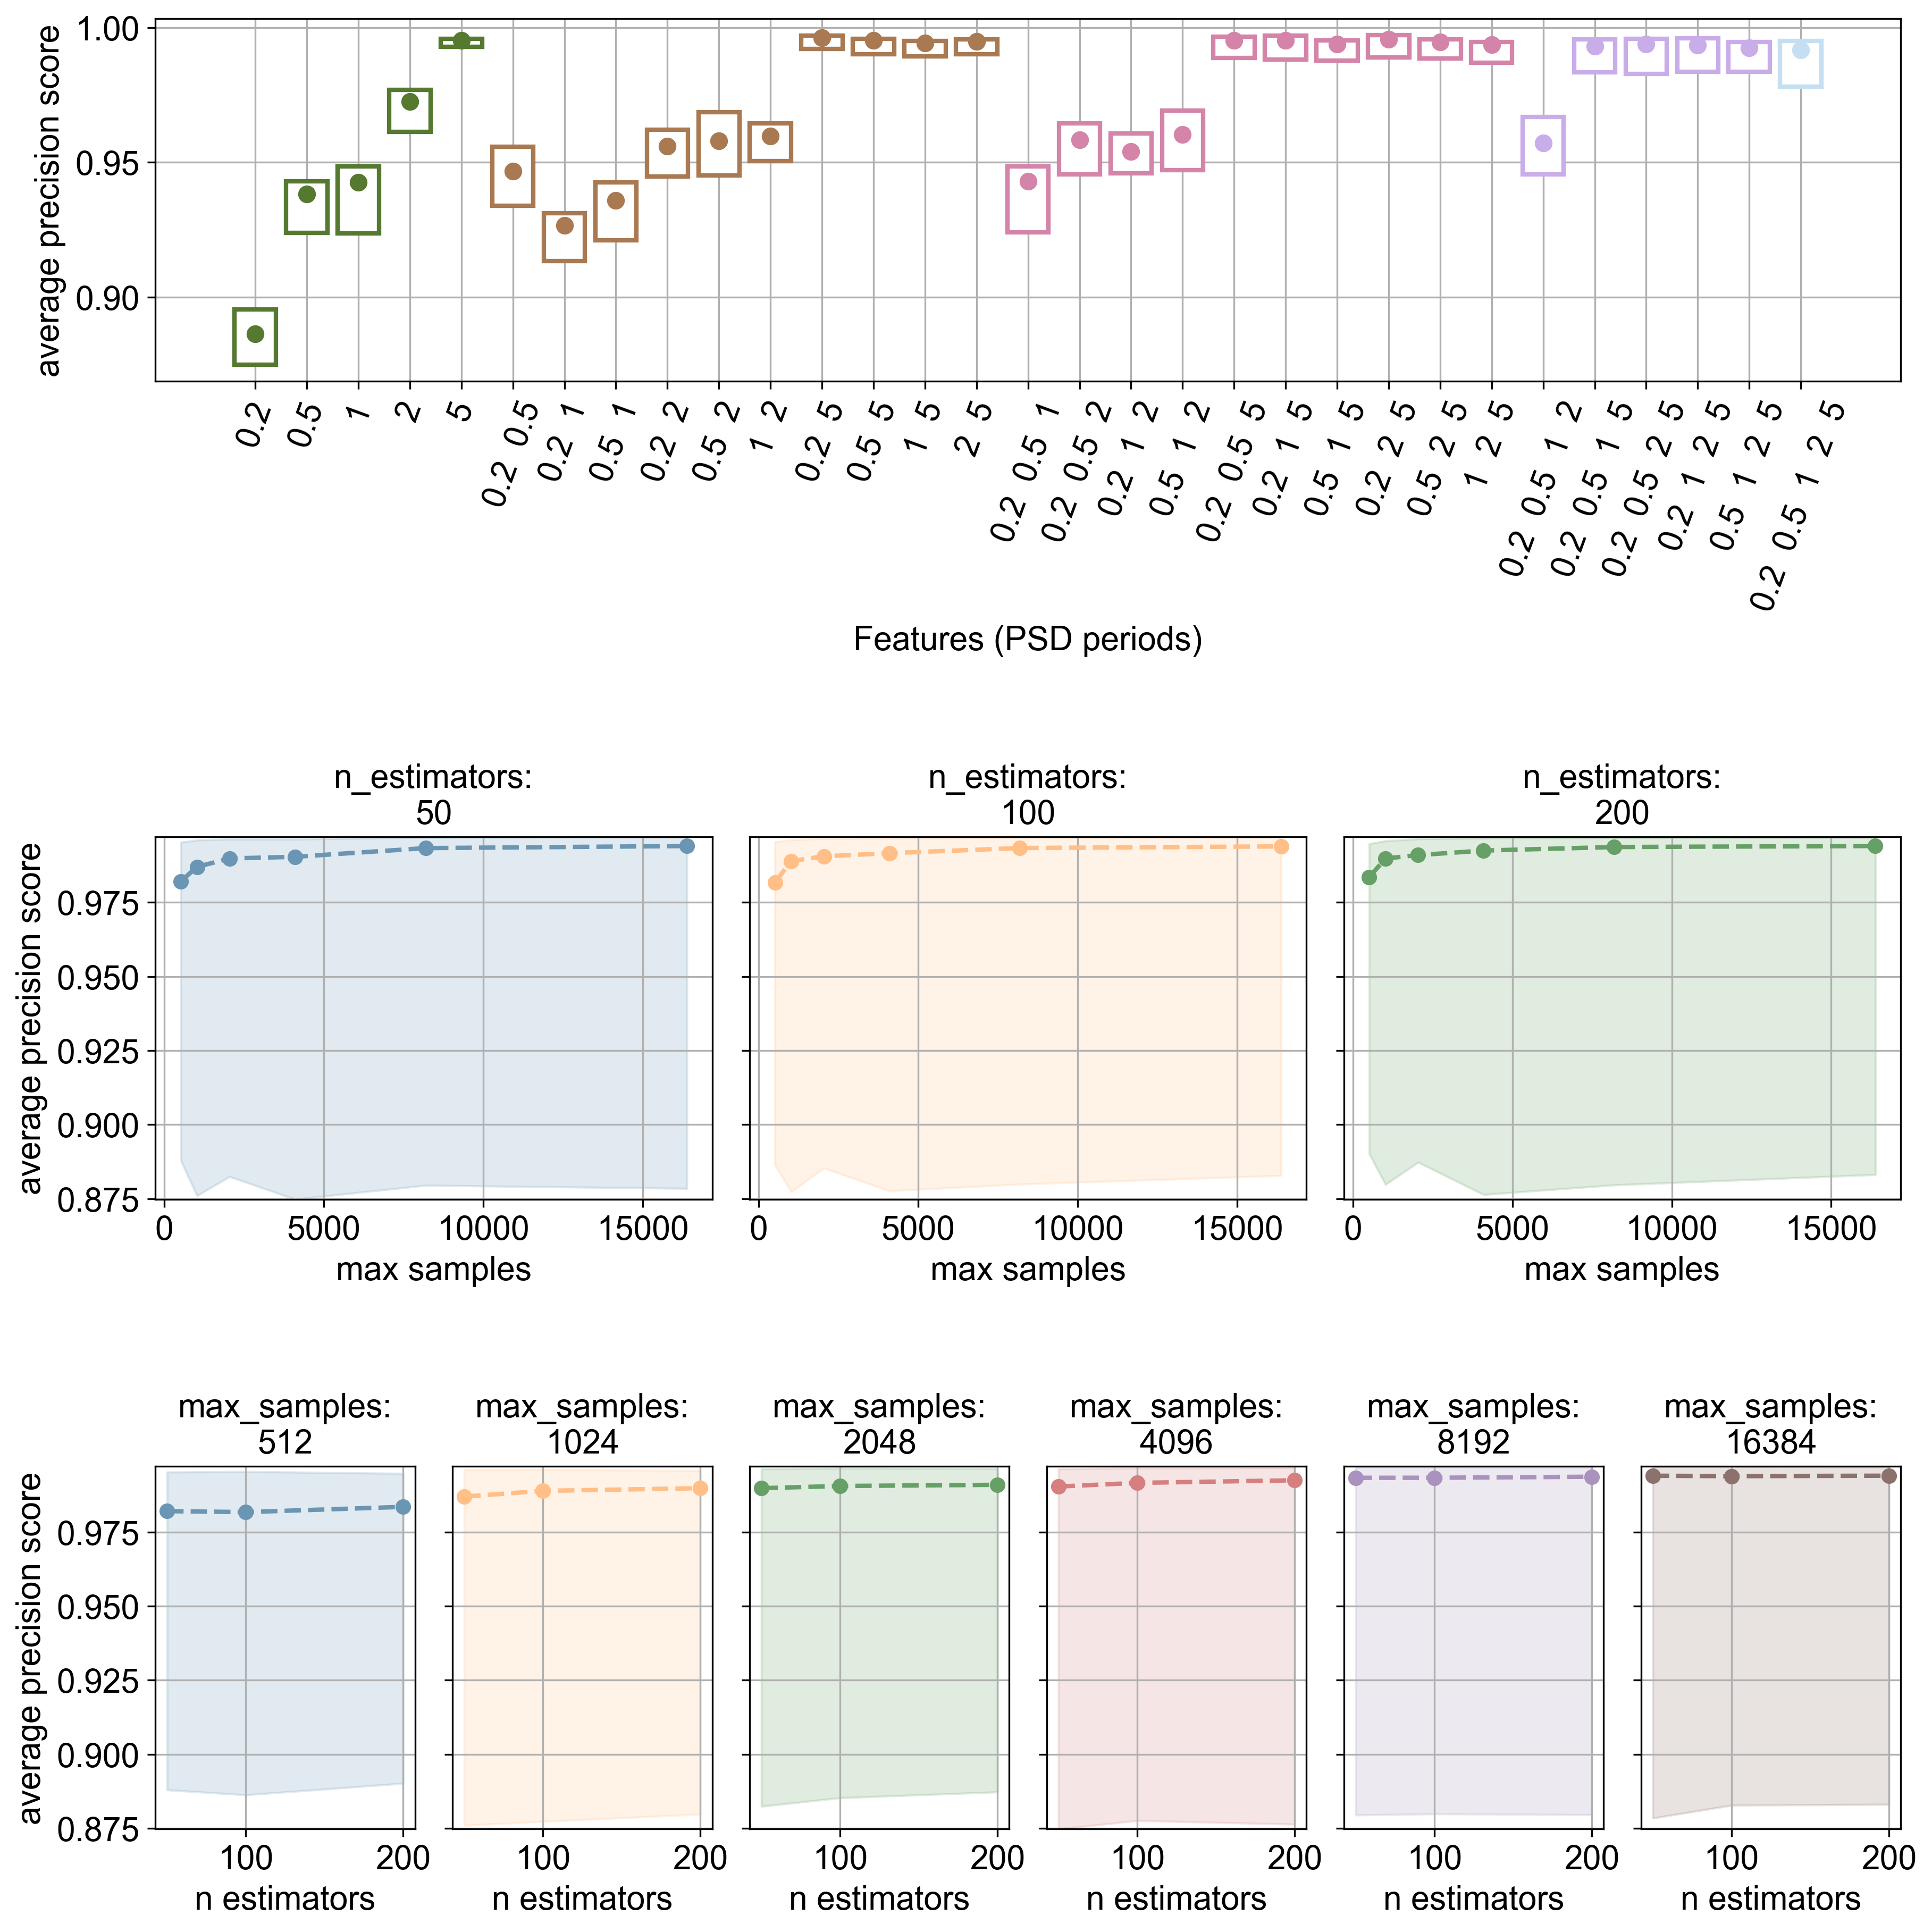

In [6]:
evalinfo(sem_df, 'average_precision_score')

roc_auc_score

Min roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.8369  0.8084  0.8236  0.8059  0.8184  0.8101
             100      0.8366  0.8078  0.8269  0.8102  0.8192  0.8238
             200      0.8438  0.8165  0.8338  0.8084  0.8150  0.8259

Median roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9841  0.9872  0.9893  0.9902  0.9923  0.9928
             100      0.9824  0.9893  0.9907  0.9913  0.9922  0.9929
             200      0.9852  0.9902  0.9911  0.9916  0.9925  0.9926

Max roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9957  0.9961  0.9962  0.9964  0.9965  0.9970
             100      0.9954  0.9962  0.9964  0.9964  0.9965  0.9970
             200      0.9951  0.9960  0.9964  0.9965  0.9965  0.9965

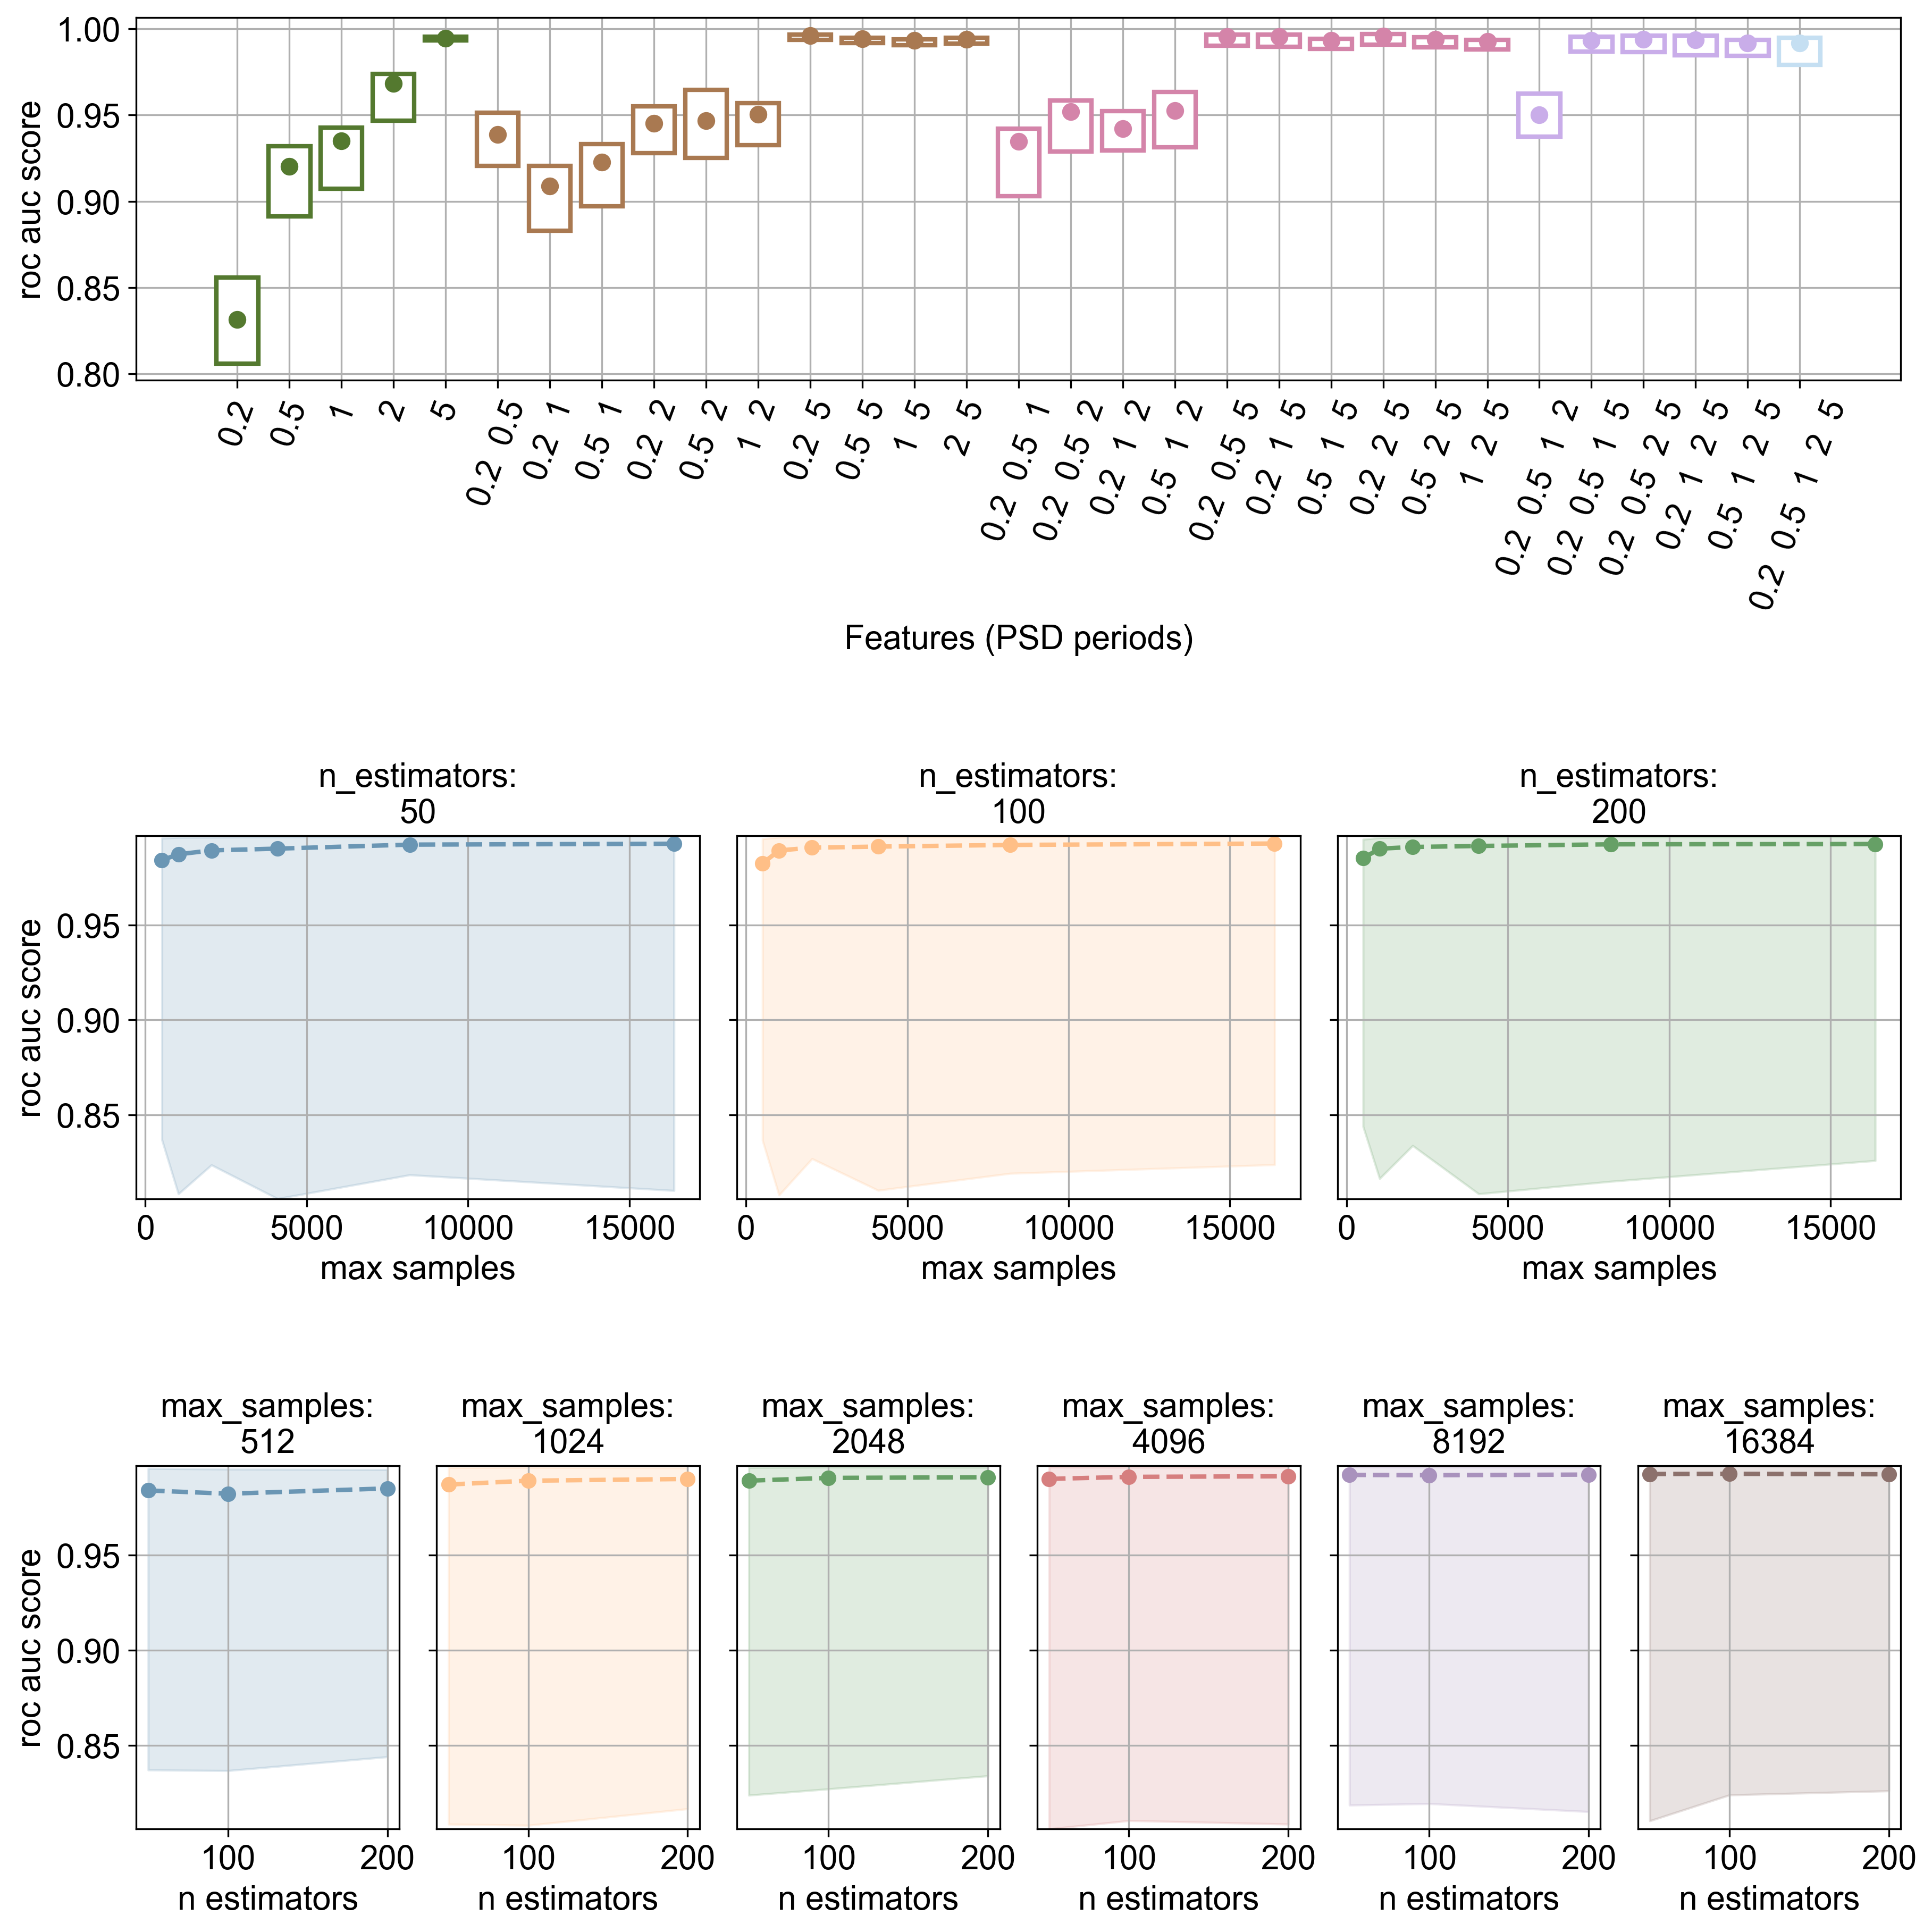

In [7]:
evalinfo(sem_df, 'roc_auc_score')

In [8]:
# We do not show the mean log loss as not informative: the distribution of samples is not symmetric,
# and inliers tend to have scores ~= 0.4 whereas outliers are close to 0.8. A logarithmic measure
# of how points are "close" from 0 and 1, respectively, is affected by this bias

# evalinfo(sem_df, 'log_loss')

In [9]:
printhtml('<h3>Using only evaluations with features containing psd@5sec (`sem_df2`)</h3>')
sem_df2 = sem_df[sem_df.feats.str.contains('psd@5sec')]

Using only evaluations with features containing psd@5sec (`sem_df2`)

average_precision_score

Min average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9781  0.9855  0.9875  0.9898  0.9931  0.9935
             100      0.9782  0.9826  0.9880  0.9912  0.9932  0.9938
             200      0.9812  0.9871  0.9885  0.9919  0.9935  0.9936

Median average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9897  0.9926  0.9941  0.9945  0.9950  0.9952
             100      0.9900  0.9930  0.9947  0.9948  0.9949  0.9953
             200      0.9905  0.9933  0.9944  0.9948  0.9951  0.9953

Max average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9952  0.9960  0.9963  0.9963  0.9969  0.9971
             100      0.9954  0.9961  0.9965  0.9966  0.9969  0.9971
             200      0.9947  0.9957  0.9964  0.9967  0.9968  0.9969

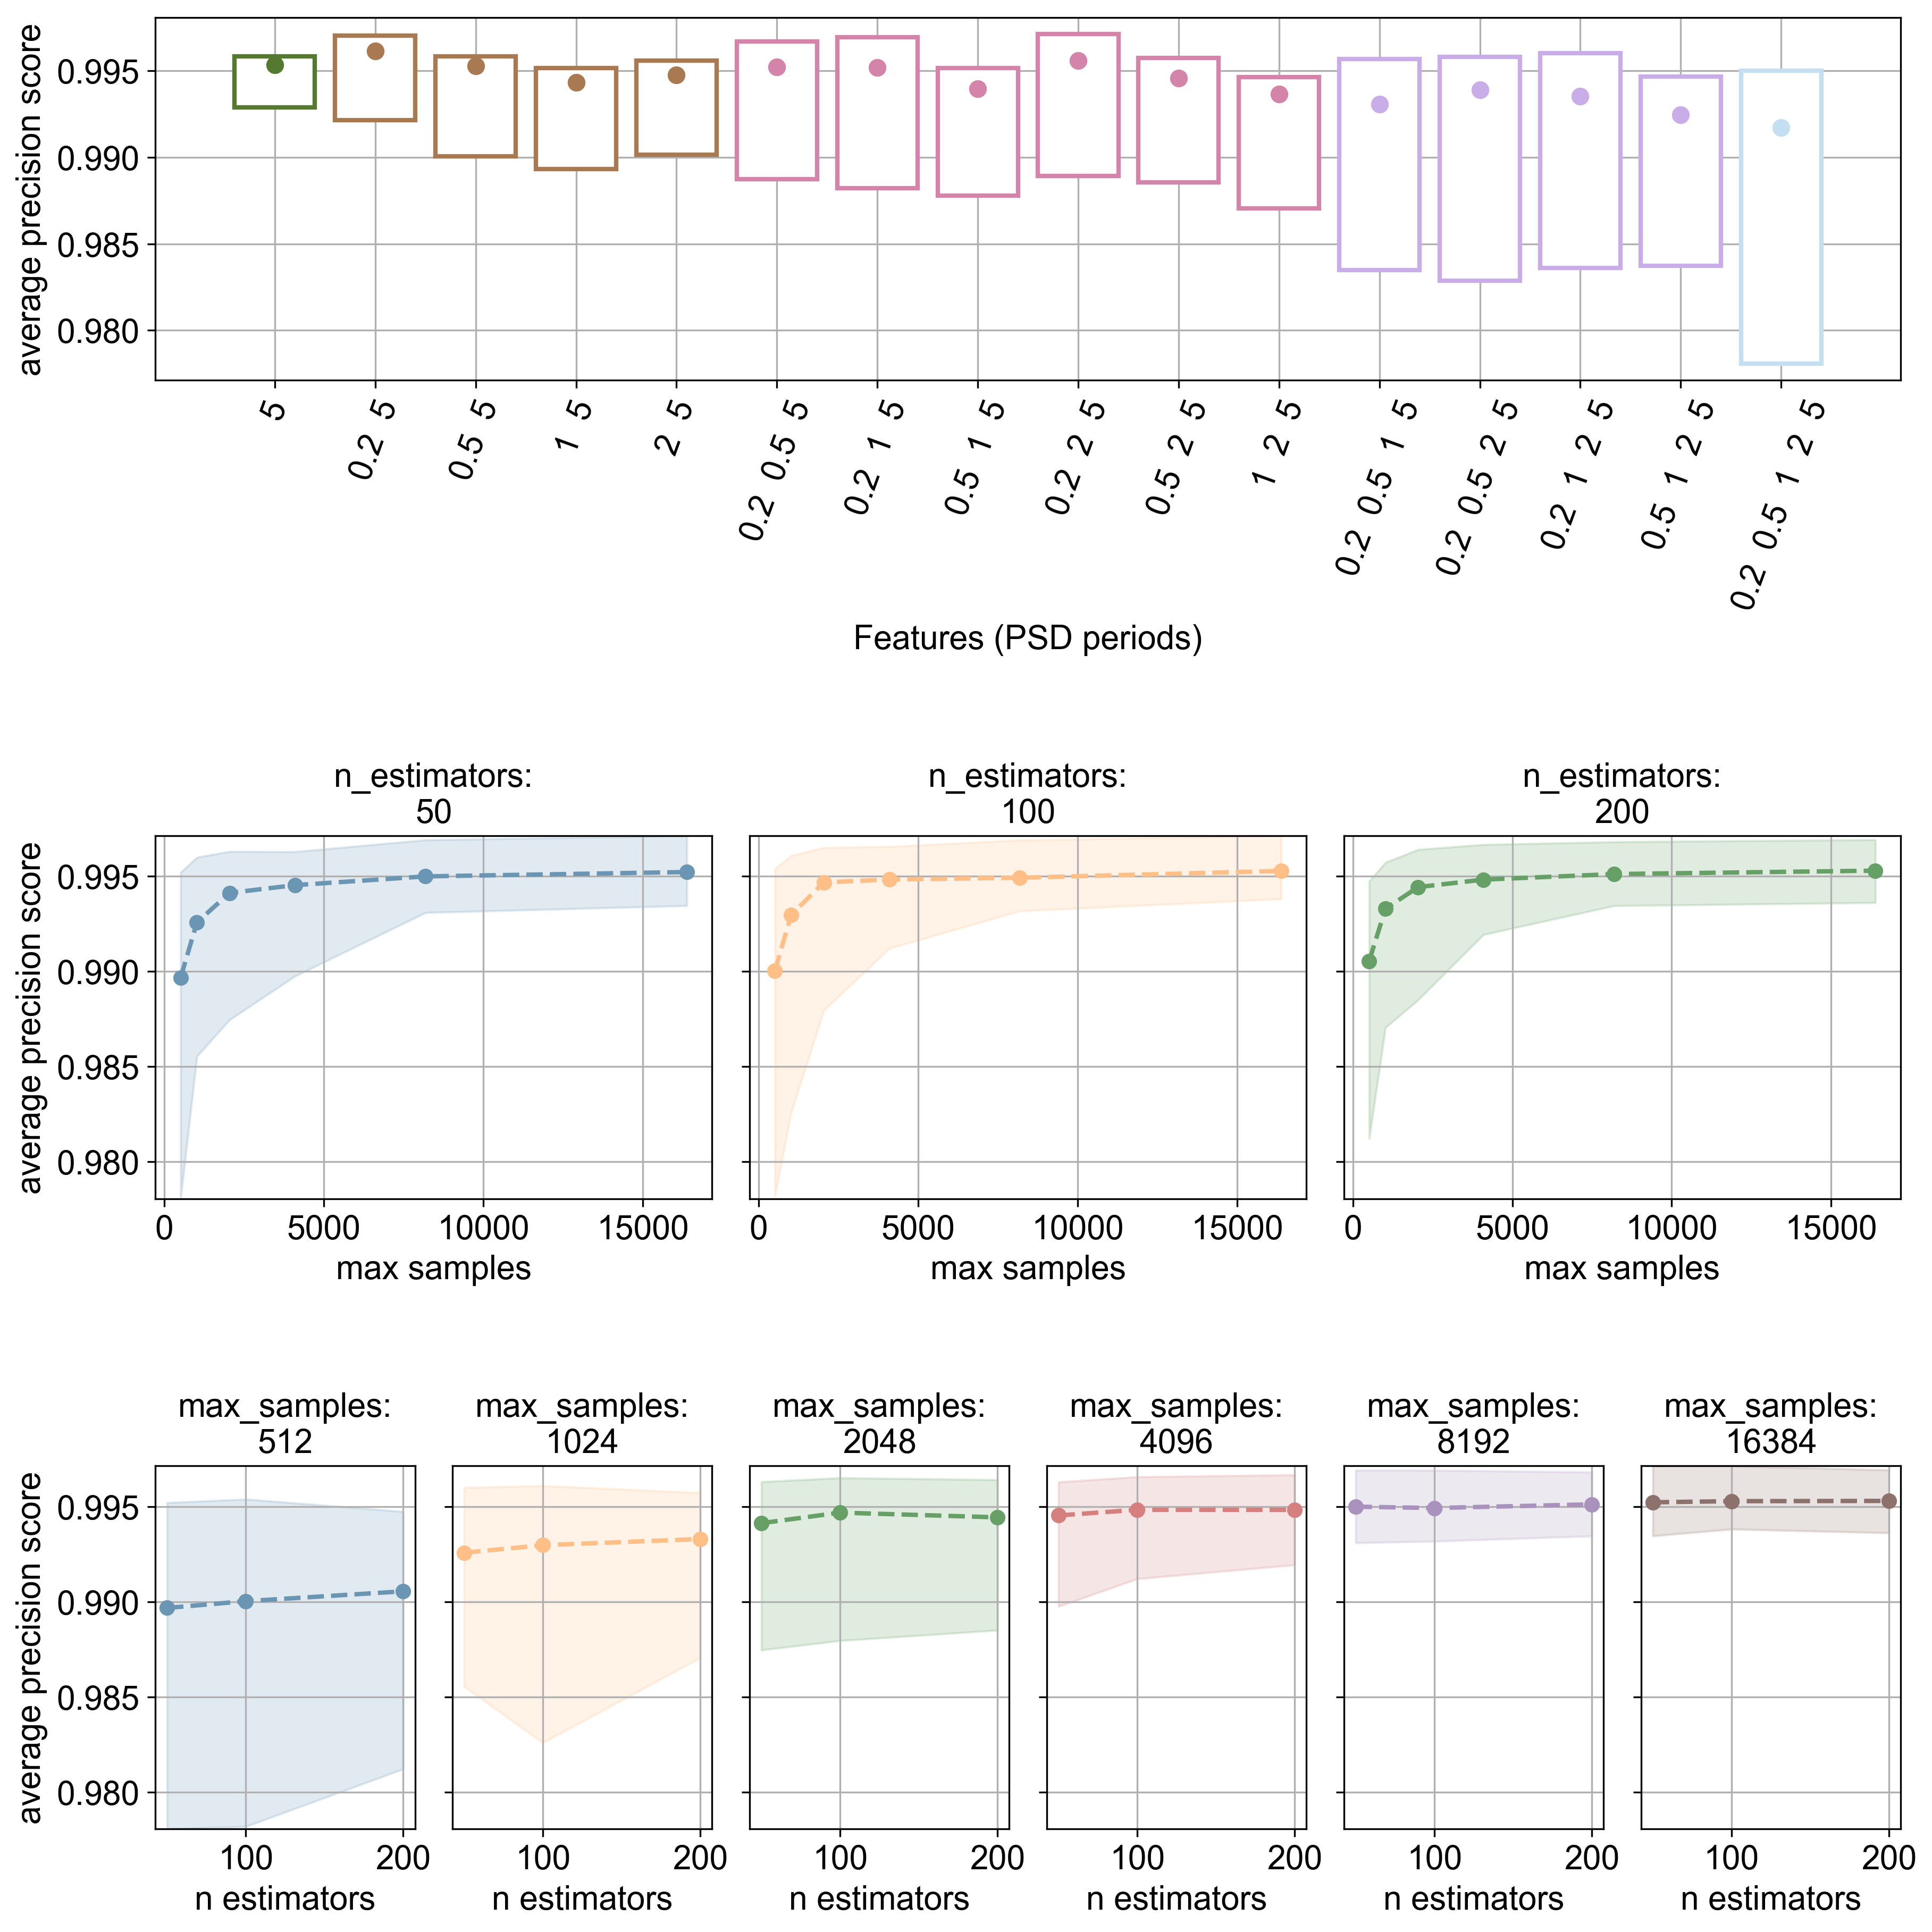

In [10]:
evalinfo(sem_df2, 'average_precision_score')

roc_auc_score

Min roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9789  0.9868  0.9878  0.9896  0.9920  0.9927
             100      0.9803  0.9839  0.9881  0.9908  0.9921  0.9927
             200      0.9826  0.9879  0.9886  0.9915  0.9922  0.9924

Median roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9908  0.9928  0.9936  0.9939  0.9943  0.9946
             100      0.9909  0.9930  0.9940  0.9940  0.9941  0.9945
             200      0.9914  0.9930  0.9938  0.9942  0.9943  0.9944

Max roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9957  0.9961  0.9962  0.9964  0.9965  0.9970
             100      0.9954  0.9962  0.9964  0.9964  0.9965  0.9970
             200      0.9951  0.9960  0.9964  0.9965  0.9965  0.9965

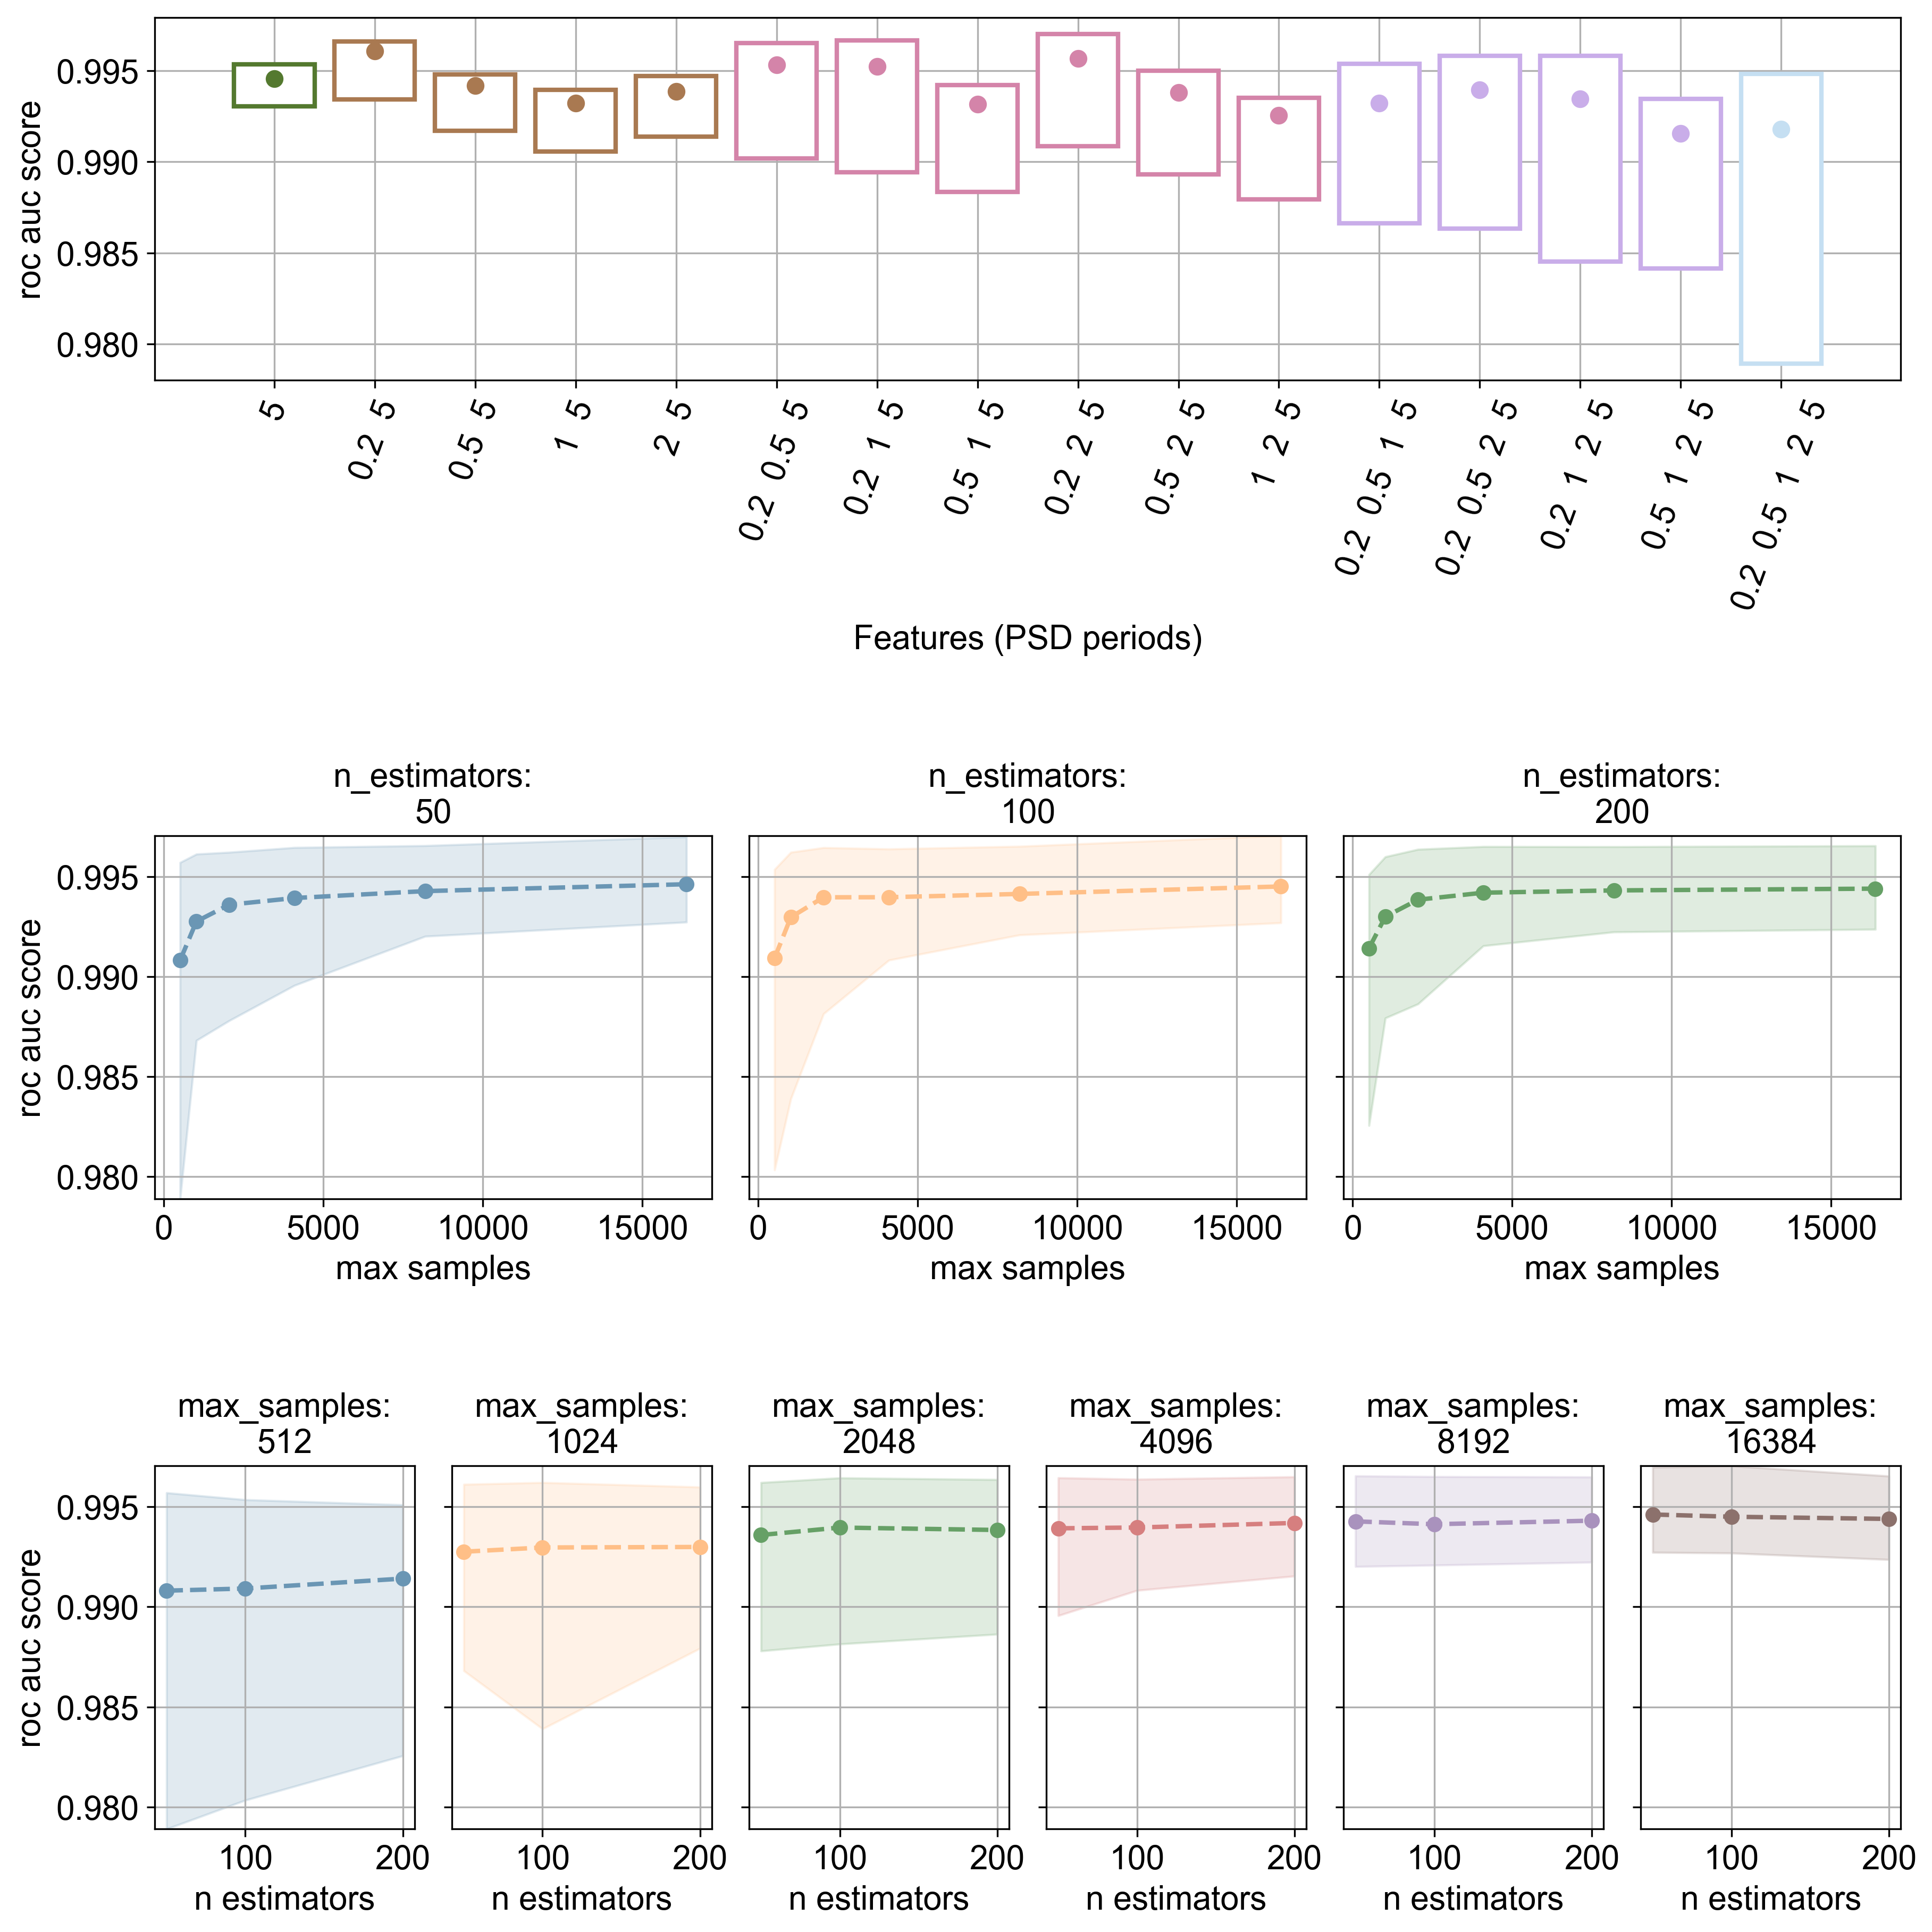

In [11]:
evalinfo(sem_df2, 'roc_auc_score')

In [12]:
# see notes above about log loss

# evalinfo(sem_df2, 'log_loss')

In [13]:
# for the paper: print auc + aps for ALL features, then
# print APS hyperparams for best features only

Summary evaluation plots (hyperparameters plot only on features containing "psd@5sec")

average_precision_score

Min average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9781  0.9855  0.9875  0.9898  0.9931  0.9935
             100      0.9782  0.9826  0.9880  0.9912  0.9932  0.9938
             200      0.9812  0.9871  0.9885  0.9919  0.9935  0.9936

Median average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9897  0.9926  0.9941  0.9945  0.9950  0.9952
             100      0.9900  0.9930  0.9947  0.9948  0.9949  0.9953
             200      0.9905  0.9933  0.9944  0.9948  0.9951  0.9953

Max average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9952  0.9960  0.9963  0.9963  0.9969  0.9971
             100      0.9954  0.9961  0.9965  0.9966  0.9969  0.9971
             200      0.9947  0.9957  0.9964  0.9967  0.9968  0.9969

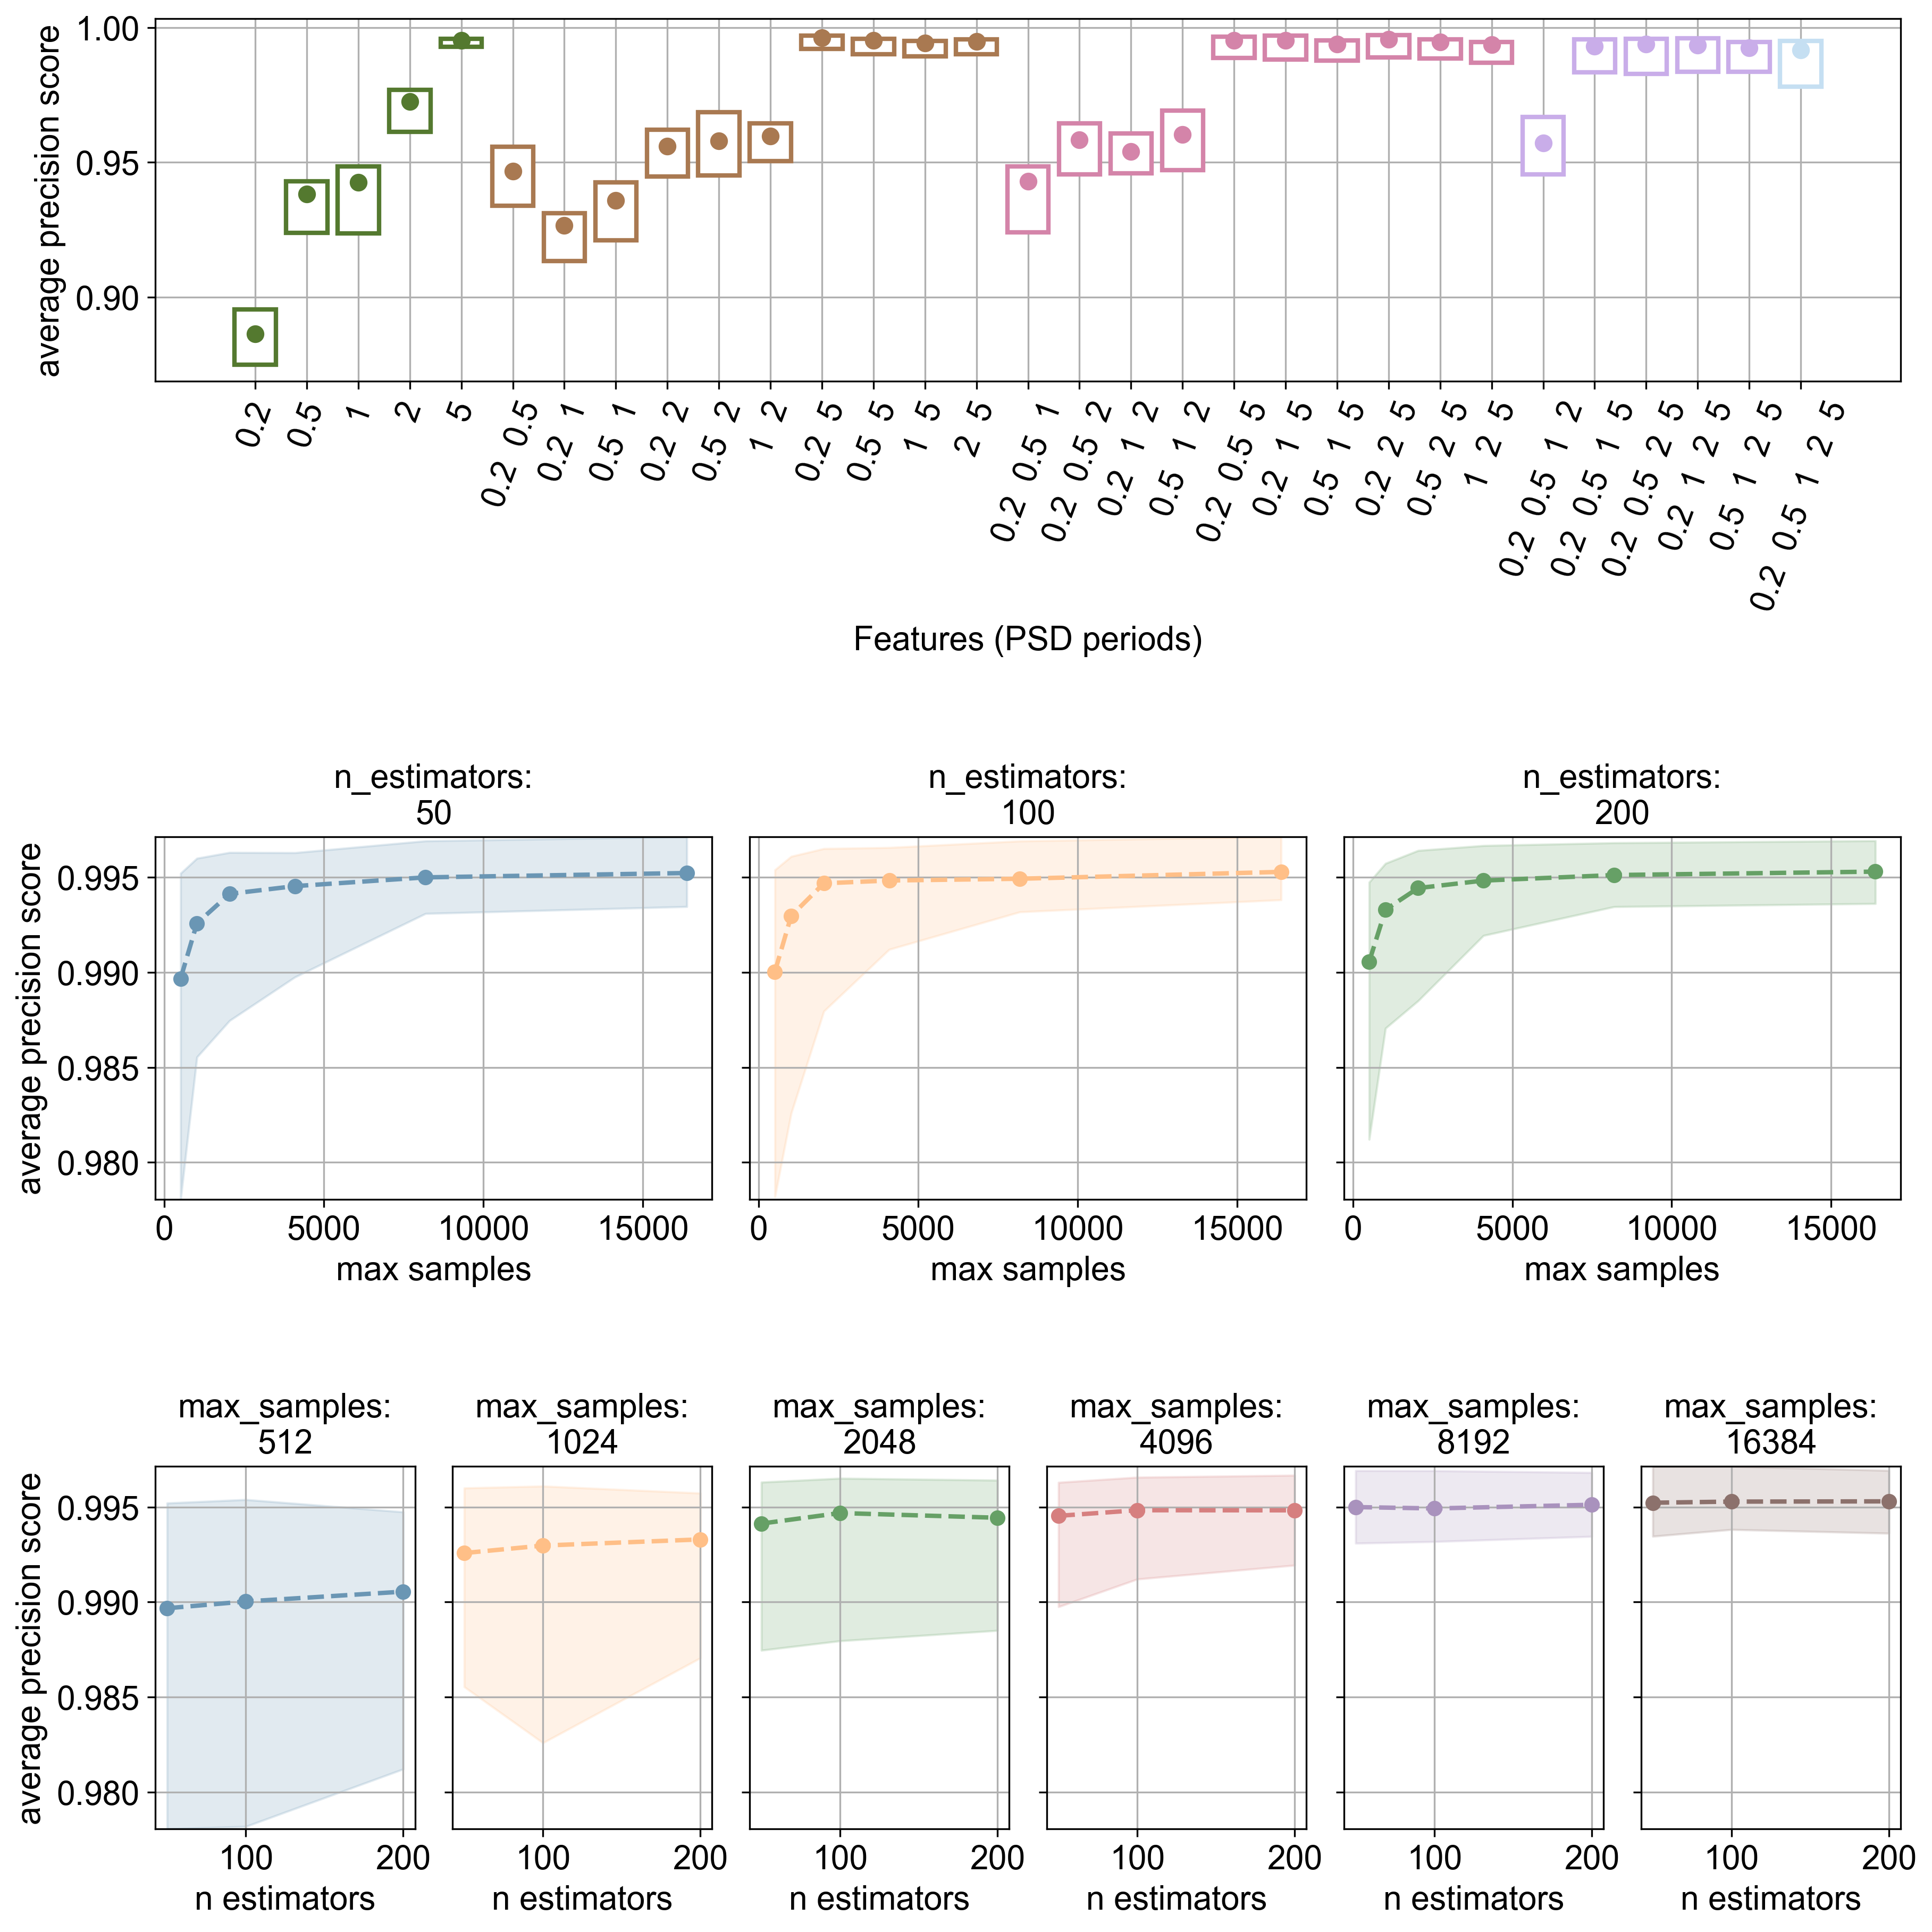

In [14]:
printhtml('<h3>Paper evaluation plot (hyperparameters plot only on features containing "psd@5sec")</h3>')
evalinfo(sem_df, 'average_precision_score', sem_df_hyperparams = sem_df2)